# 词向量与词嵌入

本章介绍词嵌入（word embedding）方法。依次有如下内容：
1. 概述
2. 机器学习对于词的表示方法
3. 神经网络语言模型（Neural Network Language Model）
4. word2vec构造词向量
5. 使用keras完成词向量的训练与可视化

### 机器学习对于词的表示方法

在NLP建模中，最重要和最根本的任务就是在模型中对输入的单词进行表示，方便模型识别单词之间的相似性和差异性。词的表达主要有两大类：早期的NLP工作中，词的表示大多是基于基本符号（atomic symbol）；而在现代NLP中，更多的是以词向量（word vector）的方法来表示，从而使得词间相似性计算更加便捷。下面先简要介绍早期的词表示方法，再着重解释现代的词向量方法。

#### 词向量方法

在真实世界中，单词的数量是巨大的。比如根据现代汉语词典，中文里常用的基本词和词组大约有5万6千多个，加上现在网络上新兴的各种单词及其组合，则无人有过精确统计；至于英语，韦伯斯特词典则大约收录了1百万个英语单词。当然，汉语的词数量不适宜跟英语相比，中文的词主要是一个词根作用，加上其各种组合应该数量也是巨大的。

这些单词之间并不是完全独立的，也不是每一个单词都代表一个完全独立的概念。我们可以认为我们在谈话时所表达的实际语义实际更少，是在一个数量更低的维度上。比如性别（男 vs 女）；交通工具（汽车 vs 飞机），食品（宫保鸡丁 vs 火锅）等等。

我们下面介绍几种常见的词向量表示方法：
1. 独热编码（One Hot Encoding）
2. 基于SVD的编码
3. 迭代编码方法

#### 独热编码 （One Hot Encoding）

独热编码是对于当前单词表中的单词使用一个向量进行表达的简单方式。假如当前的单词表有10个不同的单词，那么独热编码使用10位的0、1数字来对该单词表进行编码，出现每个单词在对应的序号位标为1，否则为0。下面举例说明：

假设我们的文档分词后产生如下的单词表：[“中国”，“国家”，“主席”，“习近平”，“北京”，“钓鱼台”，“会见”，“到”，“访”，“日本”，“首相”]，共11个单词，并且单词序号也按照上面的次序，那么我们的独热编码$w$就使用一个11个0、1数字的向量来表示这些单词：

w(“中国”)：1000000000； w(“国家”)：01000000000，......，w(“首相”)：00000000001

一般说来，对于一个具有N个元素的单词表，独热编码将每一个单词映射为$R^{1\times|N|}$的向量，向量中对应单词序号的位置数值为1，其余为0。

当然，独热编码虽然简单，但是其有几个问题：
1. 存储效率极低
2. 每个单词是完全独立的存在，之间并无联系。比如$w （“中国”）^T w（“日本”）=0$



#### 基于SVD的编码
我们看到，独热编码虽然简单，但是对于建模来说并不是较好的选择。研究者探索了可以解决存储效率和单词之间关系问题的方法，其中基于SVD的编码便是较常见的一种。这种方法依赖于通过word-document矩阵生成的共生矩阵（cooccurance matrix），下面分别介绍：
1. 词-文矩阵（word-document matrix）。这是以单词为行，以文本为列的矩阵，反映一个文本中以0、1编码表示的所有单词；
2. 基于滑动窗的共生矩阵（window based co-occurance matrix）。该矩阵是一个“词-词矩阵”（word-word matrix），反映的是在一个给定的窗口中两个单词同时出现的频次统计；

直接按照逻辑来实现对以上矩阵的生产并不难，但是sklearn里面已经有现成的方法可供调用，直接对以列表形式出现的文本集合进行操作，非常方便。下面先举一个简单示例说明逻辑，再展示实践中可用的生产性代码。在英文文档中，可以直接使用sklearn的文字处理模块进行操作，但是中文需要先进行分词再使用sklearn的模块进行处理。

下面，我们：
- 首先展示如何生成**词-文矩阵**；
- 再展示如何生成基于滑动窗的**共生矩阵**；


In [107]:
# 对于英文文档列表，可以直接使用sklearn工具生成 WORD-DOCUMENT Matrix 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from IPython.display import SVG, display

%matplotlib inline

docs = ['this is a good book',
        'this cat is this good',
        'cat dog fight']
count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
X = count_model.fit_transform(docs)
print(count_model.get_feature_names())
print(X.todense())
print(count_model.vocabulary_)

['book', 'cat', 'dog', 'fight', 'good', 'is', 'this']
[[1 0 0 0 1 1 1]
 [0 1 0 0 1 1 2]
 [0 1 1 1 0 0 0]]
{'this': 6, 'is': 5, 'good': 4, 'book': 0, 'cat': 1, 'dog': 2, 'fight': 3}


**对中文进行“词-文矩阵”生成**

英文没有分词的要求，所有单词由空格自然分开；但是中文由于其特殊性，需要进行额外分词。这里我们使用流行的“结巴分词”（jieba）软件包来进行分词，读者也可以选择自己的分词软件。

从上面的英文例子我们看到，对于中文文本，只需要将连续的中文使用jieba进行分词，将单词用空格隔开后放入一个字符串即可使用sklearn的现成方法生成词-文矩阵。下面我们进行演示。第一步我们需要将原有中文字符串列表中的中文字符串进行分词，再用空格连接后形成新的字符串放回列表中。

根据jieba分词库的自我介绍，其支持三种分词模式：
- 精确模式，试图将句子最精确地切开，适合文本分析，也是最常用的。该模式对应jieba.cut方法，使用**cut_all=False**选项
- 全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快而且颗粒度非常高，但是不能解决歧义，比如“...川普通过...”会被切分为“川普”，“普通”等多个词，但是这里实际上只有“川普”这个词有意义。该模式也对应jieba.cut方法，使用**cut_all=True**选项
- 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。该模式对应**jieba.cut_for_search**方法。

在jieba3k中，以上两种方法都返回一个可迭代的生成器（generator）对象，可以使用for 循环来获取分割后的单词。jieba分词会将阿拉伯数字单独分割出来，如果需要将这些阿拉伯数字挑出来，可以使用bool(re.search('\d+', word))来判断。

在老版本的jieba.cut和jieba.cut_for_search各自对应一个返回列表的函数，分别是lcut 和lcut_for_search，其用法一样，只是返回数据类型是一个列表，但是在jieba3k中似乎没有这些方法了。

jieba也自带一个Tokenizer对象，可新建一个自定义的分词器，使用不同的词典，这里不再详述。

对于我们的应用来说，只需要选好一个分词模式，对于原有中文字符串列表进行迭代，对于每一个字符串分词后的单词用空格连接起来再放回列表即可，下面的代码演示了采用精确模式进行分词的应用。

In [108]:
import jieba
import re
# 主动初始化jieba分词包
jieba.initialize()  
# 简单示例
documents = [u'独热编码是对于当前单词表中的单词使用1个向量进行表达的简单方式，独热编码有自身的缺点和有点。', 
             u'假如当前的单词表有10个不同的单词，并且每个单词都不一样', 
             u'研究者探索了可以解决存储效率和单词之间关系问题的方法', 
             u'独热编码虽然简单']

documents_after = []

# 第一步先将中文词切分开，每个原有中文字符串组成一个单独的列表
documents_after = [[w for w in jieba.cut(s)] for s in documents]
# 第二部用空格将单独列表中的中文词元素连接成一个带空格的字符串，从而可以模仿英文的操作
documents_after = [ ' '.join(s) for s in documents_after]
print(documents_after)
print(len(documents_after))

['独热 编码 是 对于 当前 单词表 中 的 单词 使用 1 个 向量 进行 表达 的 简单 方式 ， 独热 编码 有 自身 的 缺点 和 有点 。', '假如 当前 的 单词表 有 10 个 不同 的 单词 ， 并且 每个 单词 都 不 一样', '研究者 探索 了 可以 解决 存储 效率 和 单词 之间 关系 问题 的 方法', '独热 编码 虽然 简单']
4


下面进行矩阵构建操作，这里我们使用类似处理英文的标准方法。

In [109]:
print(u'中文分词后的文档：')
print(documents_after)
print('\n')

# 再使用sklearn模块生成word-document矩阵
cn_count_model = CountVectorizer(ngram_range=(1,1), lowercase=False) # default unigram model, 缺省要小写变换在中文中不适用，会报错
cnX = cn_count_model.fit_transform(documents_after)

print(u'标注化（Tokenized）后的特征列表：')
print(cn_count_model.get_feature_names())
print('\n')

print(u'词-文矩阵：')
print(cnX.todense())
print('\n')

print(u'词-文矩阵对应的特征索引号（矩阵列的序号）：')
print(cn_count_model.vocabulary_)
print('\n')

# 将词-文矩阵的列打上标签：
voc_df=pd.DataFrame.from_dict(cn_count_model.vocabulary_, columns=['idx'], orient='index').sort_values(by=['idx'])
cols = list(voc_df.index)
print('带标签的词-文矩阵:')
pd.DataFrame(cnX.todense(), columns=cols)

中文分词后的文档：
['独热 编码 是 对于 当前 单词表 中 的 单词 使用 1 个 向量 进行 表达 的 简单 方式 ， 独热 编码 有 自身 的 缺点 和 有点 。', '假如 当前 的 单词表 有 10 个 不同 的 单词 ， 并且 每个 单词 都 不 一样', '研究者 探索 了 可以 解决 存储 效率 和 单词 之间 关系 问题 的 方法', '独热 编码 虽然 简单']


标注化（Tokenized）后的特征列表：
['10', '一样', '不同', '之间', '使用', '假如', '关系', '单词', '单词表', '可以', '向量', '存储', '对于', '并且', '当前', '探索', '效率', '方式', '方法', '有点', '每个', '独热', '研究者', '简单', '编码', '缺点', '自身', '虽然', '表达', '解决', '进行', '问题']


词-文矩阵：
[[0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 2 0 1 2 1 1 0 1 0 1 0]
 [1 1 1 0 0 1 0 2 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0]]


词-文矩阵对应的特征索引号（矩阵列的序号）：
{'独热': 21, '编码': 24, '对于': 12, '当前': 14, '单词表': 8, '单词': 7, '使用': 4, '向量': 10, '进行': 30, '表达': 28, '简单': 23, '方式': 17, '自身': 26, '缺点': 25, '有点': 19, '假如': 5, '10': 0, '不同': 2, '并且': 13, '每个': 20, '一样': 1, '研究者': 22, '探索': 15, '可以': 9, '解决': 29, '存储': 11, '效率': 16, '之间': 3, '关系': 6, '

,10,一样,不同,之间,使用,假如,关系,单词,单词表,可以,...,研究者,简单,编码,缺点,自身,虽然,表达,解决,进行,问题
0,0,0,0,0,1,0,0,1,1,0,...,0,1,2,1,1,0,1,0,1,0
1,1,1,1,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0


我们发现上述操作是可行的，因此可以将第一步的操作封装为一个函数供后续步骤使用。

In [110]:
documents2 = [u'独热编码是对于当前单词表中的单词使用1个向量进行表达的简单方式，独热编码有自身的缺点和有点。']
documents2_after = [[w for w in jieba.cut(s)] for s in documents2]
documents2_after = [ ' '.join(s) for s in documents2_after]
print(documents2_after)

['独热 编码 是 对于 当前 单词表 中 的 单词 使用 1 个 向量 进行 表达 的 简单 方式 ， 独热 编码 有 自身 的 缺点 和 有点 。']


In [111]:
def cn_string_to_words(documents):
    # 第一步先将中文词切分开，每个原有中文字符串组成一个单独的列表
    documents_after = [[w for w in jieba.cut(s)] for s in documents]
    # 第二部用空格将单独列表中的中文词元素连接成一个带空格的字符串，从而可以模仿英文的操作
    documents_after = [ ' '.join(s) for s in documents_after]
    return documents_after

但是在实际工作中存在大量文本，我们会发现不同词的出现频率非常不同。这时候单纯使用词-文矩阵里面的频率计数到模型中会造成有偏差的结果。事实上，如果一个不常见的词在某一个文本中出现，那么其携带的信息量反而是非常高的。一种常见的变换方法就是TF-IDF（term-frequency inverse document frequency）。这个方法将高频词按照在所有文本中出现的频次进行降低权重的操作，从而来“突出”低频词的作用。tfidf使得文本相对更可比，计算文本之间的相似性的时候更有意义。

TFIDF在sklearn里面有现成的工具进行操作。

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

cn_tf_model = TfidfVectorizer()
X = cn_tf_model.fit_transform(documents_after)
print(cn_tf_model.get_feature_names())
print(X.shape)

voc_df=pd.DataFrame.from_dict(cn_tf_model.vocabulary_, columns=['idx'], orient='index').sort_values(by=['idx'])
cols = list(voc_df.index)
print('带标签的词-文矩阵:')
Xdf=pd.DataFrame(X.todense(), columns=cols)
# 现在行对应单词，列对应文本
Xdf.T


['10', '一样', '不同', '之间', '使用', '假如', '关系', '单词', '单词表', '可以', '向量', '存储', '对于', '并且', '当前', '探索', '效率', '方式', '方法', '有点', '每个', '独热', '研究者', '简单', '编码', '缺点', '自身', '虽然', '表达', '解决', '进行', '问题']
(4, 32)
带标签的词-文矩阵:


,0,1,2,3
10,0.000000,0.335714,0.000000,0.000000
一样,0.000000,0.335714,0.000000,0.000000
不同,0.000000,0.335714,0.000000,0.000000
之间,0.000000,0.000000,0.309976,0.000000
使用,0.248108,0.000000,0.000000,0.000000
假如,0.000000,0.335714,0.000000,0.000000
关系,0.000000,0.000000,0.309976,0.000000
单词,0.158364,0.428563,0.197854,0.000000
单词表,0.195611,0.264680,0.000000,0.000000
可以,0.000000,0.000000,0.309976,0.000000


#### 滑动窗口的共生矩阵生成
滑动窗口的共生矩阵因为包含了两个单词在一定相邻距离上同时出现的频次，因此反映了单词之间的相关程度。

如果不考虑窗口大小，从而在全局考虑共生矩阵的生成的化，只需要使用词-文矩阵的矩阵乘积即可，下面展示：

In [113]:
documents = [u'独热编码是对于当前单词表中的单词使用1个向量进行表达的简单方式，独热编码有自身的缺点和有点。', 
             u'假如当前的单词表有10个不同的单词，并且每个单词都不一样', 
             u'研究者探索了可以解决存储效率和单词之间关系问题的方法', 
             u'独热编码虽然简单']
documents_after  = cn_string_to_words(documents)

# 再使用sklearn模块生成word-document矩阵
min_n = 1
max_n = 1
cn_count_model = CountVectorizer(ngram_range=(min_n, max_n), lowercase=False) # 缺省为 unigram 模型
cnX = cn_count_model.fit_transform(documents_after)


print(u'共生矩阵：')
#cnXdense = cnX.todense()
#%time XTX = np.dot(cnXdense.T, cnXdense)
%time XTX = cnX.T * cnX
print(XTX.todense(), '\n')


print(u'词-文矩阵对应的特征索引号（矩阵列的序号）：')
print(cn_count_model.vocabulary_)
print('\n')

# 将共生矩阵的列打上标签：
voc_df=pd.DataFrame.from_dict(cn_count_model.vocabulary_, columns=['idx'], orient='index').sort_values(by=['idx'])
cols = list(voc_df.index)
print('带标签的共生矩阵:')
pd.DataFrame(XTX.todense(), columns=cols, index=cols)

共生矩阵：
Wall time: 997 µs
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]] 

词-文矩阵对应的特征索引号（矩阵列的序号）：
{'独热': 21, '编码': 24, '对于': 12, '当前': 14, '单词表': 8, '单词': 7, '使用': 4, '向量': 10, '进行': 30, '表达': 28, '简单': 23, '方式': 17, '自身': 26, '缺点': 25, '有点': 19, '假如': 5, '10': 0, '不同': 2, '并且': 13, '每个': 20, '一样': 1, '研究者': 22, '探索': 15, '可以': 9, '解决': 29, '存储': 11, '效率': 16, '之间': 3, '关系': 6, '问题': 31, '方法': 18, '虽然': 27}


带标签的共生矩阵:


,10,一样,不同,之间,使用,假如,关系,单词,单词表,可以,...,研究者,简单,编码,缺点,自身,虽然,表达,解决,进行,问题
10,1,1,1,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
一样,1,1,1,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
不同,1,1,1,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
之间,0,0,0,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,1
使用,0,0,0,0,1,0,0,1,1,0,...,0,1,2,1,1,0,1,0,1,0
假如,1,1,1,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
关系,0,0,0,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,1
单词,2,2,2,1,1,2,1,6,3,1,...,1,1,2,1,1,0,1,1,1,1
单词表,1,1,1,0,1,1,0,3,2,0,...,0,1,2,1,1,0,1,0,1,0
可以,0,0,0,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,1


如果要生成含有特定窗口宽度的共生矩阵，这时我们需要自己写一个移动窗口函数，对于任意给定的单词（以下标index表示），在其左右给定窗口范围内获取邻近词。该操作可以使用如下的list comprehension操作实现：
start = index - window_size
end = index + window_size + 1
neighbor_words = [words[i] for i in range(start, end) if 0 <= i < L and i != index]

其中，L是字符串长度。注意，这里我们的输入是已经转换为下标的，以空格间隔的中文单词字符串。

下面，我们先使用一个双重list comprehension将中文单词依照单词表转换为下标。由于下标0在keras的所有文字处理方法中都是保留下标，程序不会认为该数字对应于一个单词，因此这里我们也将sklearn生成的下标值+1。

其次再编写一个函数，使用移动窗口技巧获取临近单词。

In [114]:
vocabulary = cn_count_model.vocabulary_
V = len(vocabulary)
documents_index = [[vocabulary[word]+1 for word in doc.split(' ') if word in vocabulary.keys()] for doc in documents_after]
print(documents_index)

[[22, 25, 13, 15, 9, 8, 5, 11, 31, 29, 24, 18, 22, 25, 27, 26, 20], [6, 15, 9, 1, 3, 8, 14, 21, 8, 2], [23, 16, 10, 30, 12, 17, 8, 4, 7, 32, 19], [22, 25, 28, 24]]


In [115]:
from keras.preprocessing import sequence
from keras.utils import np_utils
def generate_cooccurancemat(corpus, window_size, V):
    maxlen = window_size*2
    result = np.zeros([V, V], dtype=int)    
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            #获取index对应的近邻词列表
            contexts = []                 
            s = index - window_size
            e = index + window_size + 1            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            #对于该共生组合，对于其相应矩阵位置计数+1
            for k in x[0]:
                if k!=0:
                    result[word-1, k-1] += 1                        
    return result

In [116]:
cooccurancemat = generate_cooccurancemat(documents_index, 3, V)
pd.DataFrame(cooccurancemat, columns=cols, index=cols)

,10,一样,不同,之间,使用,假如,关系,单词,单词表,可以,...,研究者,简单,编码,缺点,自身,虽然,表达,解决,进行,问题
10,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
一样,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
不同,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
之间,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
使用,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
假如,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
关系,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
单词,1,1,1,1,1,0,1,2,2,0,...,0,0,0,0,0,0,0,1,1,1
单词表,1,0,1,0,1,1,0,2,0,0,...,0,0,1,0,0,0,0,0,0,0
可以,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


在上面的例子中因为信息量较小，两个词同时出现多次的情况没有，因此这里使用较大的外部数据来进行展示。我们使用的是1000条酒店评论数据。

In [117]:
def load_hotel_data():
    documents2 = []
    stopword = []
    datafile_pos = './nlp_data/hotel_reviews_data/1000_pos.txt'
    datafile_neg = './nlp_data/hotel_reviews_data/1000_neg.txt'
    stopwordfile = './nlp_data/hotel_reviews_data/stopWord.txt'

    # 先读入stopword
    #fo=open(stopwordfile, encoding='UTF-8')
    with open(stopwordfile, encoding='UTF-8') as fo:
        for line in fo:
           stopword.append(line.strip('\n'))

    #print(stopword[70:87])

    # 再读入原始评论文档
    with open(datafile_pos, encoding='UTF-8') as fo:
        for line in fo:
           documents2.append(line.strip('\n'))

    with open(datafile_neg, encoding='UTF-8') as fo:
        for line in fo:
           documents2.append(line.strip('\n'))    
    return documents2, stopword

documents2, stopword = load_hotel_data();
print(documents2[:3])

['距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较为简单.', '商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!', '早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。']


如果滑动窗口大小设为1，则考虑全局的共生矩阵

In [118]:
# 首先分词
documents2_after = cn_string_to_words(documents2)

# 建立词表索引，用来将文字转换为下标，从而我们可以使用上面的generate_cooccurancemat函数
min_n = 1
max_n = 1
cn_count_model = CountVectorizer(ngram_range=(min_n, max_n), lowercase=False, stop_words = stopword)
cnX = cn_count_model.fit_transform(documents2_after)

vocabulary = cn_count_model.vocabulary_
# 考虑到阿拉伯数字没有多少意义，这里我们要先将阿拉伯数字从单词表中剔除。首先制作一个词典索引拷贝列表，
#其中只保留阿拉伯数字元素，再在原始词典中逐一pop出阿拉伯数字
#bool(re.search('\d+', word))
keys = list(vocabulary.keys())
vocabulary2 = vocabulary.copy()
numkeys = [k for k in keys if bool(re.search('\d+', k))]
for key in numkeys:
    vocabulary2.pop(key)

# 清洁工作
del(keys)
# 重新fit数据，但是numkeys会被添加到stopword里
stopword.extend(numkeys)
cn_count_model2 = CountVectorizer(ngram_range=(min_n, max_n), lowercase=False, stop_words = stopword)
cnX = cn_count_model2.fit_transform(documents2_after) 

vocabulary2 = cn_count_model2.vocabulary_
documents_index = [[vocabulary2[word]+1 for word in doc.split(' ') if word in vocabulary2.keys()] for doc in documents2_after]
print(documents_index[:3])

# 现在开始使用generate_cooccurancemat函数生成共生矩阵
print(u'使用generate_cooccurancemat函数生成共生矩阵：')
XTX = generate_cooccurancemat(documents_index, 10, len(vocabulary2.keys()))
print('\n')


# 将共生矩阵的列打上标签：
voc_df=pd.DataFrame.from_dict(vocabulary2, columns=['idx'], orient='index').sort_values(by=['idx'])
cols = list(voc_df.index)
print('带标签的词-文矩阵:')
pd.DataFrame(XTX, columns=cols, index=cols)

[[6867, 3111, 1368, 6956, 1349, 3951, 6438, 7723, 3340, 6884, 3769, 6947], [2247, 2579, 3769, 3452, 3285, 4185, 3666, 6094, 2876, 628], [4342, 519, 7616, 7250, 3306, 7278, 191, 7398]]
使用generate_cooccurancemat函数生成共生矩阵：


带标签的词-文矩阵:


,ACCOR,AmberleyHotel,Angel,BED,BUS,CDMA,CHACK,CHECK,CHINA,CTIRP,...,鼓励,鼓浪屿,鼓点,鼾声,齊齊,齐全,齐备,龙城,龙头,龙门石窟
ACCOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AmberleyHotel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BED,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BUS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDMA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHACK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHECK,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
CHINA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CTIRP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


我们可以将共生矩阵进行SVD分解，获取每个单词在新空间上的映射向量

In [119]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
%time svd.fit(XTX)
u = svd.transform(XTX)

Wall time: 6.92 s


(-2.25, 2.25)

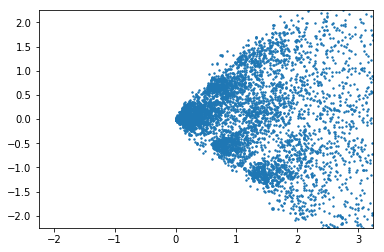

In [120]:
plt.scatter(u[:, 0], u[:, 1], s=2)
plt.xlim(-2.25, 3.25)
plt.ylim(-2.25, 2.25)

** 这里结束传统的基于词频的表达方法，开始介绍基于预测的表达方法。**

### 迭代嵌入方法
我们在上面介绍了基于SVD的词嵌入方法。通过共生矩阵以及SVD算法，独热法表示的单词之间的关系得到抽象，并映射到较低维度的致密空间中。但是这种方法基于全局信息，对存储量需求大。我们现在介绍一种迭代学习的方法来将单词映射到一个新的包含了上下文关系的空间中。这种方法的典型代表叫word2vec。在word2vec这个方法中需要引入两个概念“中心词”（center word）和“上下文”（context）

以“资产富裕的人爱投资股票”这句话为例，其经过处理后得到如下的单词：\[ '资产','富裕'，'人', '爱', '投资', '股票' \]。如果选定*‘富裕’*这个单词，在模型中其被称为“中心词”，而其上下文就是前后的\[ '资产','人', '爱', '投资', '股票' \]。一个中心词的上下文被word2vec这个算法用来衡量其含义。如果我们在大量的文本中都发现类似于“资产”，“财富”，“投资”这样的词经常性地出现在*“富裕”*这个词的周边，就能推断*“富裕”*的含义。有相似上下文的词就在word2vec这个模型里具备相似的含义，可以被视作是同义词，其对应的词向量则应该距离上接近。

当然，在实践中，上下文通常被定义为中心词左右对称给定长度的窗口覆盖的词，如下图所示：

<img src="./pics/Chapter1-1.png" width="400">
"中心词与上下文的独热表示"

在word2vec中，词向量本身就是模型的参数，通过对数据的建模可以获得参数的值。word2vec包含两种不同的子模型：
1. 连续型模型（Continuous Bag Of Words Model, CBOW Model）
2. 跳跃型模型（Skip-Gram Model）

下面分别介绍。

** 连续型模型 （CBOW） **

在CBOW中，模型是根据上下文单词来预测中心词。其基本步骤如下：


其架构如下图所示（图源自于："Deep learning for sentence classification"）。图中标识分别为：
1. $x_{ik}$为独热表示的上下文单词
2. $W_{V \times N}$为输入层的权重矩阵，大小为$V \times N$，其中V是词典大小，而N是设定的词向量维度
3. $h_i$是由$x_{ik}$与权重矩阵$W$相乘的到的隐含层结果，大小为$1 \times N$的向量
4. $W^{'}_{N \times V}$为输出层的权重矩阵。注意，这里的$W^{'}$不是$W$矩阵的转置，而是另外一个全新的矩阵。
5. $y_j$为待预测的中心词的独热表示


<img src="./pics/Chapter1-CBOW.png" width="400">


CBOW的计算过程比较直接：

1. 首先，对于给定窗口长度m，上下文$x^{(c)}$用相应的独热法表示，对于待预测的中心词$y^{(c)}$也用相应的独热编码表示，那么我们的输入数据为：$(x^{(c-m)},...,x^{(c-1)}, x^{(c+1)},..., x^{(c+m)} )$。不过在keras中我们无需直接输入独热法表示的单词，而是输入单词对应的索引号，keras会自动处理。
2. 其次，对于上述上下文单词，与输入层权重矩阵相乘，得到嵌入向量$v_{c-m} = Wx^{(c-m)}, v_{c-m+1} = Wx^{(c-m+1)}, ....$
3. 将上述嵌入向量取平均：$\bar(v) = \frac{\sum_{-m}^{m}v_{c+j}}{2m}$
4. 将平均的嵌入向量与输出层权重矩阵相乘，得到输出打分向量$z = W{'}\bar{v}$。相似的单词该得分应该更高；
5. 应用softmax函数将上述打分向量变为概率输出$y=\textrm{softmax}(z)$。如果预测准确的话，那么概率向量$y$会在独热编码为1的地方具备最高的概率值。

word2vec模型就是要在迭代的过程中，通过不断优化$W$和$W'$两个权重矩阵使得我们的语言模型尽可能地接近实际的数据表现。下图是CBOW模型的一个实现的架构图（图片来自于网络）：
<img src="./pics/Chapter1-CBOW-model.png" width="400">

我们在后面一节详细讲解CBOW的keras实现。

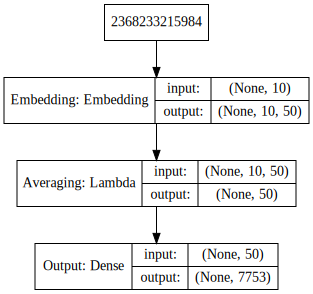

In [121]:
import keras.backend as K
from keras.models import Sequential
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.layers import Dense, Embedding, Lambda
from IPython.display import SVG, display

V = len(vocabulary2)
embedding_dim = 50
window_size = 5

cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=embedding_dim, input_length=window_size*2, name='Embedding'))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,), name='Averaging'))
cbow.add(Dense(V, activation='softmax', name='Output'))
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')
display(SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg')))

** 跳跃型模型 （Skip-Gram） **

Skip-Gram模型与CBOW正好相反，模型是根据中心词来预测上下文。其基本步骤如下：


其架构如下图所示（图源自于："Deep learning for sentence classification"）。图中标识分别为：
1. $x_{ik}$为独热表示的中心词
2. $W_{V \times N}$为输入层的权重矩阵，大小为$V \times N$，其中V是词典大小，而N是设定的词向量维度
3. $h_i$是由$x_{ik}$与权重矩阵$W$相乘的到的隐含层结果，大小为$1 \times N$的向量
4. $W^{'}_{N \times V}$为输出层的权重矩阵。注意，这里的$W^{'}$不是$W$矩阵的转置，而是另外一个全新的矩阵。
5. $y_{Cj}$为待预测的上下文词的独热表示

<img src="./pics/Chapter1-SkipGram.png" width="400">

Skip-Gram模型试图通过学习不同组合的词在同一个句子中同时出现的概率来的到词。对于每一个给定的单词，文本中越靠近这个单词的词应该有更高的概率出现在一起，而与这个单词距离相隔较远的词其共同出现的概率会低一些。比如对于“研究者 探索 了 可以 解决 存储 效率 和 单词 之间 关系 问题 的 方法”这句话，Skip-Gram模型试图去最大化$p(研究者|概率)$这个概率值，但是同时要最小化诸如$p(可以|方法)$或者$p(问题|可以)$这样的组合。后面这类组合被称为负样本，或者噪音样本。

对于模型训练需要的数据而言，当两个词出现在同一个窗口内的上下文中时，这个组合会被标注为1，作为正样本；否则标注为0，作为负样本。以上面的句子为例，["存储", "效率"]，["问题", "关系"]这样的组合都是正样本。但是负样本就多种多样了，任意不在上下文窗口中同时出现的单词组合都是负样本，比如["关系", "研究者"]， ["可以", "方法"]，等等。

这就带来了一些问题，由于这种负样本的词组合极大，会使得训练数据非常大，训练非常慢。但是其实从模型训练的角度来说，并不需要所有的负样本对应的单词组合，只要有典型的有代表性的就可以。因此，在Skip-Gram模型中引入了Negative Sampling（NS）的概念。这里以指定的相对于正样本的概率对所有可能出现的负样本单词组合进行取样。但是如果简单地进行随机抽样，那么高频词组合出现的概率天然比低频词组合高，会给模型拟合带来不良影响，我们实际上需要减少高频词被抽样抽中的概率，因为低频词的信息含量相对更高。这就是Negative Sampling的思想。

## 中文字符预处理：

如前所述在我们编写自己的CBOW或者SkipGram模型之前，我们先要对中文字符进行处理。虽然前面我们已经有了一些方法来处理中文，但是是改造的sklearn的方法。由于我们的模型需要使用keras来编写，因此考虑能不能将中文处理纳入keras的文字预处理模块？下面我们将对keras的文字预处理模块进行改造，使其标注类（Tokenizer）能顺利处理中文。我们将从一下几个方面着手。

1. 中文标注类（tokenizer），这个需要继承并改造现有的基于英文的标注类（Tokenizer），将英文的分词部分用jieba分词代替
2. 序列化，这个基于jieba分词返回的带空格中文文本列表，改造现成的序列化方法即可
3. 建立字典，这个在标注类中可以在拟合过程中生成
4. 建立正向、反向查阅表，这个可以在标注类的拟合过程中生成

下面是我们针对中文改造的标注类及相关方法。主要改造围绕text_to_word_sequence这个方法，将切分使用jieba.cut()方法来实现。

In [122]:
from collections import defaultdict
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer
def cntext_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',):
    """
    Transform each text in Chinese texts to a sequences of Chinese words
    """    
    translate_dict = dict((c, ' ') for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    words = jieba.cut(text)
    seq = [w for w in words if w]
    return seq

    
def cntexts_to_sequences(texts, num_words, oov_token, document_count, filters, word_index ):
    """Transforms each text in Chinese texts to a sequence of integers.
    Only top `num_words-1` most frequent words will be taken into account.
    Only words known by the tokenizer will be taken into account.
    # Arguments
        texts: A list of texts (strings).
    # Returns
        A list of sequences.
    """
    return list(cntexts_to_sequences_generator(texts, num_words, oov_token, document_count, filters, word_index))    


def cntexts_to_sequences_generator(texts, num_words, oov_token, document_count, filters, word_index ):
    """Transforms each Chinese text in `texts` to a sequence of integers.
    Each item in texts can also be a list,
    in which case we assume each item of that list to be a token.
    Only top `num_words-1` most frequent words will be taken into account.
    Only words known by the tokenizer will be taken into account.
    # Arguments
        texts: A list of texts (strings).
    # Yields
        Yields individual sequences.
    """
    num_words = num_words
    oov_token_index = word_index.get(oov_token)
    for text in texts:
        document_count += 1
        #print(text)

        if isinstance(text, list):
            longtext = ' '.join(text)           
            text = longtext
        seq = cntext_to_word_sequence(text, filters)
        #print(seq, '\n')
                
        vect = []
        temp = []
        for w in seq:
            i = word_index.get(w)
            temp.append(i)
            if i is not None:
                if num_words and i >= num_words:
                    if oov_token_index is not None:
                        vect.append(oov_token_index)
                else:
                    vect.append(i)
            elif oov_token is not None:
                vect.append(oov_token_index)
        #print(temp)
        #print('-------------')
        yield vect       

        
class cnTokenizer(Tokenizer):
    """Text tokenization utility class.
    This class allows to vectorize a text corpus, by turning each
    text into either a sequence of integers (each integer being the index
    of a token in a dictionary) or into a vector where the coefficient
    for each token could be binary, based on word count, based on tf-idf...
    # Arguments
        num_words: the maximum number of words to keep, based
                   on word frequency. Only the most common `num_words-1` words will
                   be kept.
        filters: a string where each element is a character that will be
                 filtered from the texts. The default is all punctuation, plus
                 tabs and line breaks, minus the `'` character.
        lower: boolean. Whether to convert the texts to lowercase.
        split: str. Separator for word splitting.
        char_level: if True, every character will be treated as a token.
        oov_token: if given, it will be added to word_index and used to
                   replace out-of-vocabulary words during text_to_sequence calls
    By default, all punctuation is removed, turning the texts into
    space-separated sequences of words
    (words maybe include the `'` character). These sequences are then
    split into lists of tokens. They will then be indexed or vectorized.
    `0` is a reserved index that won't be assigned to any word.
    """

    def __init__(self, num_words=None,
                 filters='!！"#$%&()（）*+，。；,-./:;《<=>》?@【[\\]】^_`——{|}~\t\n',
                 lower=True,
                 split=' ',
                 char_level=False,
                 oov_token=None,
                 document_count=0,
                 **kwargs):
        # Legacy support
        if 'nb_words' in kwargs:
            warnings.warn('The `nb_words` argument in `Tokenizer` '
                          'has been renamed `num_words`.')
            num_words = kwargs.pop('nb_words')
        if kwargs:
            raise TypeError('Unrecognized keyword arguments: ' + str(kwargs))

        self.word_counts = OrderedDict()
        self.word_docs = defaultdict(int)
        self.filters = filters
        self.split = split
        self.lower = lower
        self.num_words = num_words
        self.document_count = document_count
        self.char_level = char_level
        self.oov_token = oov_token
        self.index_docs = defaultdict(int)
        self.word_index = dict()
        self.index_word = dict()
            
    def fit_on_cntexts(self, texts):
        '''
        假设输入是一组中文列表
        '''
        for text in texts:
            self.document_count += 1

            if isinstance(text, list):
                longtext = ' '.join(text)           
                text = longtext
            seq = cntext_to_word_sequence(text, self.filters)
            for w in seq:
                if w in self.word_counts:
                    self.word_counts[w] += 1
                else:
                    self.word_counts[w] = 1
            for w in set(seq):
            # In how many documents each word occurs
               self.word_docs[w] += 1

        wcounts = list(self.word_counts.items())
        wcounts.sort(key=lambda x: x[1], reverse=True)
        # forcing the oov_token to index 1 if it exists        
        if self.oov_token is None:
            sorted_voc = []
        else:
            sorted_voc = [self.oov_token]
        sorted_voc.extend(wc[0] for wc in wcounts)

        # note that index 0 is reserved, never assigned to an existing word
        self.word_index = dict(
                list(zip(sorted_voc, list(range(1, len(sorted_voc) + 1))))
        )

        self.index_word = dict((c, w) for w, c in self.word_index.items())

        for w, c in list(self.word_docs.items()):
            self.index_docs[self.word_index[w]] = c

    
    def cntexts_to_sequences(self, texts):
        """Transforms each text in texts to a sequence of integers.
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Returns
            A list of sequences.
        """
        return list(self.cntexts_to_sequences_generator(texts))    

    def cntexts_to_sequences_generator(self, texts):
        """Transforms each text in `texts` to a sequence of integers.
        Each item in texts can also be a list,
        in which case we assume each item of that list to be a token.
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Yields
            Yields individual sequences.
        """
        num_words = self.num_words
        oov_token_index = self.word_index.get(self.oov_token)
        for text in texts:
            self.document_count += 1

            if isinstance(text, list):
                longtext = ' '.join(text)           
                text = longtext
            seq = cntext_to_word_sequence(text, self.filters)
                    
            vect = []
            for w in seq:
                i = self.word_index.get(w)
                if i is not None:
                    if num_words and i >= num_words:
                        if oov_token_index is not None:
                            vect.append(oov_token_index)
                    else:
                        vect.append(i)
                elif self.oov_token is not None:
                    vect.append(oov_token_index)
            yield vect            




下面我们实验一下。

In [123]:
documents = [u'独热编码是对于当前单词表中的单词使用1个向量进行表达的简单方式，独热编码有自身的缺点和有点。', 
             u'研究者探索了可以解决存储效率和单词之间关系问题的方法', 
             u'独热编码虽然简单', 
             u'假如当前的单词表有10个不同的单词，并且每个单词都不一样']

corpus = documents
tokenizer = cnTokenizer()
tokenizer.fit_on_cntexts(documents)
V = len(tokenizer.word_index) + 1
text_sequences=tokenizer.cntexts_to_sequences(documents)
#seq, word_index, index_word, word_docs, index_docs, word_counts, document_count = fit_on_cntexts(corpus)
print('文本单词下标对应计数索引')
print(tokenizer.index_docs,'\n')
print('单词正向索引')
print(tokenizer.word_index, '\n')
print('单词反向索引')
print(tokenizer.index_word, '\n')
print('单词计数')
print(tokenizer.word_counts, '\n')
print('\n')
print('索引后以单词下标表示的原文本序列')
print(text_sequences)

文本单词下标对应计数索引
defaultdict(<class 'int'>, {12: 1, 19: 1, 10: 2, 13: 1, 3: 2, 7: 2, 23: 1, 21: 1, 8: 2, 11: 2, 2: 3, 1: 3, 4: 2, 9: 2, 20: 1, 17: 1, 15: 1, 22: 1, 5: 2, 6: 2, 16: 1, 14: 1, 18: 1, 34: 1, 28: 1, 24: 1, 27: 1, 26: 1, 32: 1, 33: 1, 25: 1, 31: 1, 29: 1, 30: 1, 35: 1, 40: 1, 43: 1, 36: 1, 42: 1, 41: 1, 38: 1, 37: 1, 39: 1}) 

单词正向索引
{'的': 1, '单词': 2, '独热': 3, '编码': 4, ' ': 5, '当前': 6, '单词表': 7, '个': 8, '简单': 9, '有': 10, '和': 11, '是': 12, '对于': 13, '中': 14, '使用': 15, '1': 16, '向量': 17, '进行': 18, '表达': 19, '方式': 20, '自身': 21, '缺点': 22, '有点': 23, '研究者': 24, '探索': 25, '了': 26, '可以': 27, '解决': 28, '存储': 29, '效率': 30, '之间': 31, '关系': 32, '问题': 33, '方法': 34, '虽然': 35, '假如': 36, '10': 37, '不同': 38, '并且': 39, '每个': 40, '都': 41, '不': 42, '一样': 43} 

单词反向索引
{1: '的', 2: '单词', 3: '独热', 4: '编码', 5: ' ', 6: '当前', 7: '单词表', 8: '个', 9: '简单', 10: '有', 11: '和', 12: '是', 13: '对于', 14: '中', 15: '使用', 16: '1', 17: '向量', 18: '进行', 19: '表达', 20: '方式', 21: '自身', 22: '缺点', 23: '有点', 24: '研究者', 25: '探索',

现在我们已经对keras的标准标注类做了必要的小修改，使得其能顺利地对中文文档进行标准，词典生成，序列化，建立正向和反向的查询表。

## CBOW的keras实现

下面我们在keras中来实现基于CBOW算法的word2vec模型。我们需要进行如下的设计：
1. 首先读入用于训练的中文文本
2. 其次我们要将原始输入的文字进行标注化（tokenize），下标代表每一个单词，构造单词表；
3. 构造一个CBOW数据生成器，能产出（上下文，目标单词）的组合
4. 构造CBOW的网络结构。这里需要说明几点：
   1. 在这个结构中，输入层到隐藏层之间的权重矩阵的第i行存储了单词表中第i个单词的词向量信息，因此训练得到的第一个权重矩阵就是我们需要的词向量矩阵。 
   2. 输入层和隐藏层的激活函数使用线性函数，即对输出不做特别处理。输出层使用softmax激活函数。
5. 训练CBOW模型
6. 获取词向量
7. 使用gensim来验证每个单词的相似词

步骤 1：使用前面的load_hotel_data函数载入

In [124]:
# 步骤 1：使用前面的load_hotel_data函数载入
documents2, stopword = load_hotel_data();

步骤 2：对原始数据进行标注化，生成单词查询表等核心信息，并将原始文本输出为下标序列。

In [125]:
# 步骤 2：对原始数据进行标注化。
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = cnTokenizer()
tokenizer.fit_on_cntexts(documents2)
word_index = tokenizer.word_index
text_sequences=tokenizer.cntexts_to_sequences(documents2)

vocabulary_size = len(tokenizer.word_index)
embedding_size = 100
window_size = 2 # context window size

print('单词表大小:', vocabulary_size, '\n')
print('单词表样本:', list(tokenizer.word_index.items())[10:20], '\n')
print('标注后文字样本:', text_sequences[:4], '\n')

单词表大小: 9262 

单词表样本: [('都', 11), ('还', 12), ('有', 13), ('住', 14), ('服务', 15), ('不', 16), ('好', 17), ('不错', 18), ('就', 19), ('没有', 20)] 

标注后文字样本: [[478, 3192, 2516, 1389, 1, 45, 853, 2020, 16, 90, 1, 114, 5, 1, 3193, 1, 304, 1, 125, 29, 1068, 1, 187, 98, 656, 2517, 1, 6, 3194, 1], [207, 162, 56, 1, 6, 155, 1, 3195, 2518, 2519, 1, 452, 28, 657, 598, 18, 1], [35, 78, 43, 1, 721, 24, 1154, 48, 1, 1390, 9, 5485, 1536, 2, 1, 4, 176, 1069, 242, 54, 228, 3, 1], [58, 10, 53, 5486, 55, 1, 3196, 200, 1, 30, 439, 461, 2021, 5487, 116, 1]] 



步骤 3：构造一个能产出（上下文，目标单词）组合的CBOW数据生成器。

In [126]:
def generate_cbow_pairs(corpus, window_size, vocabulary_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocabulary_size)
            yield (x, y)
            

下面来验证一下这个函数，看看生成的词组合是否是我们需要的。

In [127]:
vocabulary_size = len(tokenizer.word_index)
window_size = 2 

i = 0
for x, y in generate_cbow_pairs(corpus=text_sequences, window_size=window_size, vocabulary_size=vocabulary_size):
    if 0 not in x[0]:
        print('上下文 (X):', [tokenizer.index_word[w] for w in x[0]], 
              '-> 目标词 (Y):', tokenizer.index_word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
    i += 1

上下文 (X): ['距离', '川沙', '较近', ' '] -> 目标词 (Y): 公路
上下文 (X): ['川沙', '公路', ' ', '但是'] -> 目标词 (Y): 较近
上下文 (X): ['公路', '较近', '但是', '公交'] -> 目标词 (Y):  
上下文 (X): ['较近', ' ', '公交', '指示'] -> 目标词 (Y): 但是
上下文 (X): [' ', '但是', '指示', '不'] -> 目标词 (Y): 公交
上下文 (X): ['但是', '公交', '不', '对'] -> 目标词 (Y): 指示
上下文 (X): ['公交', '指示', '对', ' '] -> 目标词 (Y): 不
上下文 (X): ['指示', '不', ' ', '如果'] -> 目标词 (Y): 对
上下文 (X): ['不', '对', '如果', '是'] -> 目标词 (Y):  


现在可以开始构造我们的CBOW模型了。我们再来重温一遍模型的架构图：
<img src="./pics/Chapter1-CBOW-model.png" width="400">

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 4, 64)             592768    
_________________________________________________________________
Lambda (Lambda)              (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 9262)              602030    
Total params: 1,194,798
Trainable params: 1,194,798
Non-trainable params: 0
_________________________________________________________________
None


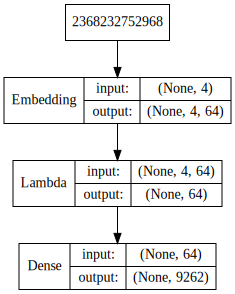

In [128]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# 用于模型可视化的函数
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 这些参数已经设置了
#vocabulary_size = len(tokenizer.word_index)
#window_size = 2 

embedding_size=64

cbow = Sequential()
cbow.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=window_size*2, name='Embedding'))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_size,), name='Lambda'))
cbow.add(Dense(vocabulary_size, activation='softmax', name='Output'))
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

# 打印模型的基本信息
print(cbow.summary())

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

下面我们就可以开始训练模型了。这里我们使用fit_generator来对数据生成器实时产出的数据进行拟合。

In [129]:
history = cbow.fit_generator(generate_cbow_pairs(corpus=text_sequences, window_size=window_size, vocabulary_size=vocabulary_size),
                             steps_per_epoch = 1000, epochs = 6)

Epoch 1/6
1000/1000 [==============================] - 4s 4ms/step - loss: 9.0778
Epoch 2/6
1000/1000 [==============================] - 4s 4ms/step - loss: 8.7875
Epoch 3/6
1000/1000 [==============================] - 4s 4ms/step - loss: 8.4824
Epoch 4/6
1000/1000 [==============================] - 4s 4ms/step - loss: 8.5745
Epoch 5/6
1000/1000 [==============================] - 4s 4ms/step - loss: 8.3032
Epoch 6/6
1000/1000 [==============================] - 4s 4ms/step - loss: 8.0897


In [130]:
# 获取输入层到隐藏层的权重信息
cbow_weights = cbow.get_weights()[0]
# 去掉偏置项
cbow_weights = cbow_weights[1:]
print(cbow_weights.shape)

# 存为pandas dataframe
cbow_weights_df = pd.DataFrame(cbow_weights, index=list(tokenizer.index_word.values())[1:])
cbow_weights_df.head()

(9261, 64)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
的,0.823650,0.471681,0.395209,-0.503302,0.572968,-0.636122,-0.616789,0.296569,-0.624792,-0.361608,...,-0.412419,0.776124,-0.406472,-0.555857,-0.650517,-0.286981,0.439726,-0.677486,-0.380361,-0.559437
了,0.294489,0.252224,0.305898,-0.253135,0.304576,-0.314885,-0.296178,0.314431,-0.334209,-0.324564,...,-0.339726,0.309556,-0.365173,-0.265704,-0.271692,-0.263214,0.299100,-0.416034,-0.289732,-0.329744
酒店,0.165804,0.167311,0.166066,-0.166291,0.184793,-0.108608,-0.139219,0.166085,-0.105535,-0.161157,...,-0.139558,0.111655,-0.133852,-0.156441,-0.117183,-0.180660,0.099741,-0.126289,-0.078849,-0.120191
是,0.198993,0.152000,0.141082,-0.183332,0.145316,-0.234583,-0.168444,0.224294,-0.215218,-0.118152,...,-0.148958,0.231947,-0.219123,-0.234873,-0.236301,-0.178482,0.198825,-0.217432,-0.226873,-0.175043
房间,0.121735,0.124491,0.181736,-0.145861,0.117333,-0.117916,-0.149748,0.166997,-0.164099,-0.163474,...,-0.114383,0.080770,-0.178408,-0.163537,-0.111148,-0.094043,0.152542,-0.199257,-0.178869,-0.184904


下面将词向量存为文本文件，供后续的gensim软件包调用来查阅给定某个单词最相似的词，或者叫最可能一起出现的词。

In [167]:
f = open('./CBOW_weights.txt' ,'w', encoding='UTF-8')
f.write(" ".join([str(vocabulary_size-1),str(embedding_size)]))
f.write("\n")
for word, i in tokenizer.word_index.items():
    if word !=' ':
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(cbow_weights[i-2,:]))))
        f.write("\n")
f.close()

In [170]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('./CBOW_weights.txt', binary=False)

w2v.most_similar('价格')

[('也', 0.8315255641937256),
 ('的', 0.8243576288223267),
 ('服务', 0.821792721748352),
 ('就', 0.8134514093399048),
 ('是', 0.8076501488685608),
 ('房间', 0.8066962957382202),
 ('了', 0.7976991534233093),
 ('在', 0.7948088645935059),
 ('我', 0.7942476868629456),
 ('有', 0.7933825254440308)]

## Skip-Gram模型的keras实现

Skip-Gram模型的实现跟CBOW模型类似，但是有其自身的特点。其模型架构通过学习CBOW模型也相对熟悉了。这里需要讲解一下数据的生成。如前所述，Skip-Gram模型依赖于成对出现的单词组，构成正样本或者负样本。keras中提供了skipgram这个函数来帮助生成所需的训练样本数据。

在Skip-Gram模型中，我们对于输入的上下文词和输出的中心词都需要做映射，并且这个模型是寻找最大化共享隐藏层的结果，因此简单的顺序模型（Sequential）无法满足需要。这里要用通用模型（Model）来构造Skip-Gram模型。

In [172]:
from keras.models import Sequential
from keras.layers import Embedding, Dot, Reshape, Activation, Flatten, Input, merge, Dense
from keras.layers.core import Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, pad_sequences
from keras import backend as K
from keras.models import Model

from gensim.models import Word2Vec

数据预处理,这里我们依然使用CBOW模型中使用的宾馆评价数据。:

In [175]:
documents2, stopword = load_hotel_data();
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = cnTokenizer()
tokenizer.fit_on_cntexts(documents2)
word_index = tokenizer.word_index
text_sequences=tokenizer.cntexts_to_sequences(documents2)

vocabulary_size = len(tokenizer.word_index)
embedding_size = 100
window_size = 2 # context window size

In [181]:
sampling_table = sequence.make_sampling_table(vocabulary_size)
couples, labels = skipgrams(text_sequences, vocabulary_size, window_size=window_size, sampling_table=None)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

ValueError: setting an array element with a sequence.

In [185]:
len(word_target)

15988

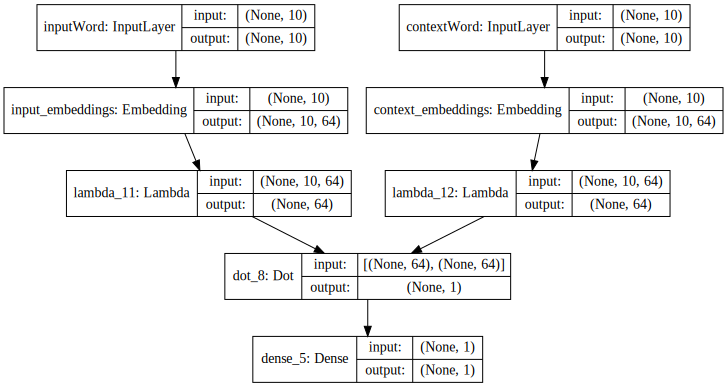

In [176]:
maxlen = 10
dim_embeddings = 64
inputs = Input(shape=(maxlen,), name = 'inputWord',dtype='int32')
context = Input(shape=(maxlen,), name = 'contextWord',dtype='int32')

embedded_sequences_input = Embedding(vocabulary_size,
                                     dim_embeddings,
                                     input_length=maxlen,
                                    name='input_embeddings',
                                    trainable=True)(inputs)
embedded_sequences_context = Embedding(vocabulary_size,
                                       dim_embeddings,
                                       input_length=maxlen,
                                       trainable=True,
                                       name='context_embeddings')(context)

embedded_sequences_input1 = Lambda(lambda s: K.sum(s, axis=1), output_shape=lambda s: (s[0],s[2]))(embedded_sequences_input)
embedded_sequences_context1 = Lambda(lambda s: K.sum(s, axis=1), output_shape=lambda s: (s[0],s[2]))(embedded_sequences_context)

final = Dot(axes=1)([embedded_sequences_input1, embedded_sequences_context1])
final = Dense(1, activation='sigmoid')(final)
skipgram = Model([inputs, context], final)
skipgram.compile(loss="categorical_crossentropy", optimizer="adam")
display(SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
history = skipgram.fit_on_generator()

对计算出来的词向量进行可视化

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
print('Please install sklearn, matplotlib, and scipy to show embeddings.')